In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from graphviz import Digraph

#Playing with backprob following Andrej Karpathy
#https://www.youtube.com/watch?v=VMj-3S1tku0&lc=UgyBMv4x57nRqR0wfGd4AaABAg

def trace(root):
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for leaf in node.inputs:
                edges.add((leaf, node))
                build(leaf)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        nstr = f"output: {node.data:.2f} | grad: {node.gradient:.2f}"
        if node.label == None:
            dot.node(name=uid, label = "{" + f" {nstr}" + "}", shape="record")
        else:
            dot.node(name=uid, label = "{" + f" {node.label} | {nstr} " + "}", shape="record")
        
        if node.op != Op and node.op != None and node.op != Input:
            dot.node(name=uid+node.mode, label=node.mode, shape="component")
            dot.edge(uid+node.mode, uid)
    for l1, l2 in edges:
        dot.edge(str(id(l1)), str(id(l2)) + l2.mode)
    return dot

class Op:
    # Signal operation mode
    @staticmethod
    def grad(signal):
        pass

class Output(Op):
    pass

class Input(Op):
    pass

class Exp(Op):
    @classmethod
    def grad(cls, signal):
        assert len(signal.inputs) == 1
        for i in signal.inputs:
            i.gradient = (signal.data * signal.gradient)

    @classmethod
    def apply(cls, *args):
        assert len(args) == 1
        (a,) = args
        return Signal(math.exp(a.data), inputs=args, op=cls)

    @classmethod
    def derivative(cls, signal):
        return Signal(signal)


class Pow(Op):
    @classmethod
    def grad(cls, signal):
        assert len(signal.inputs) == 2
        a, b = signal.inputs
        a.gradient = (b.data * (a.data ** (b.data -1)) * signal.gradient)

    @classmethod
    def apply(cls, *args):
        assert len(args) == 2
        a, b = args       
        return Signal(a.data ** b.data, inputs=args, op=cls)

            
class Add(Op):
    @classmethod
    def grad(cls, signal):
        assert len(signal.inputs) == 2
        grad = signal.gradient
        a, b = signal.inputs
        if a == b:
            a.gradient = 2 * grad
        else:
            for i in signal.inputs:
                i.gradient = (grad)
            
    @classmethod
    def apply(cls, *args):
        assert len(args) == 2
        a, b = args       
        return Signal(a.data + b.data, inputs=args, op=cls)
        
class Subtract(Op):
    @classmethod
    def grad(cls, signal):
        assert len(signal.inputs) == 2
        grad = signal.gradient
        for i in signal.inputs:
            i.gradient = (grad)
            
    @classmethod
    def apply(cls, *args):
        assert len(args) == 2
        a, b = args
        return Signal(a.data - b.data, inputs=args, op=cls)

class Multiply(Op):
    @classmethod
    def grad(cls, signal):
        assert len(signal.inputs) == 2
        grad = signal.gradient
        a, b = signal.inputs
        if a == b:
            a.gradient = (a.data * grad)*2
        else:
            a.gradient = (b.data * grad)
            b.gradient = (a.data * grad)
        

    @classmethod
    def apply(cls, *args):
        assert len(args) == 2
        a, b = args       
        return Signal(a.data * b.data, inputs=args, op=cls)

class Tanh(Op):
    @staticmethod
    def __call__(a):
        return Tanh.apply(a)
        
    @classmethod
    def grad(cls, signal):
        assert len(signal.input) == 1
        #grad = signal.gradient
        (a,) = signal.inputs
        a.gradient = (Tanh.derivative(signal).data)

    @classmethod
    def derivative(cls, signal):
        return 1 - (Tanh.apply(signal) ** 2)
        
    @classmethod
    def apply(cls, signal):
        a = Exp.apply(signal * 2)
        return (a - 1)/(a + 1)
        
class Signal:
    def __init__(self, value, inputs=(), op=Input, label=None):
        if type(value) == Signal:
            self.op = value.op
            self.label = label
            self.data = value.data
            self.inputs = value.inputs
            self.grads = value.grads
        else:   
            self.op = op
            self.label = label
            self.inputs = inputs
            self.grads = []
            self.data = value
        self.meerr = 0
        self.terminated = False
        
    @staticmethod
    def cast(values):
        return other if type(other) == Signal else Signal(other)
        
    @property
    def mode(self):
        return self.op.__name__

    @property
    def gradient(self):
        gsize = len(self.grads)
        return 1 if gsize == 0 else sum(self.grads)

    @gradient.setter
    def gradient(self, value):
        self.grads.append(value)

    def clear(self):
        self.grads = []

    def backward(self, gradient=1):
        signals = []
        visited = []
        def topo(signal):
            if signal in visited:
                return
            visited.append(signal)
            for sin in signal.inputs:
                topo(sin)
            signal.clear()
            signals.append(signal)
            
        topo(self)
        self.gradient = gradient
        for signal in reversed(signals):
            signal.op.grad(signal)
            

    def terminate(self): 
        self.terminated = True
        return self

    @property
    def output(self):
        return Tanh.apply(self)
       
        
    def __str__(self):
        return str(self.data)

    def __repr__(self):
        return f"Signal(grad={self.gradient:.4f}, data={self.data:.4f})"


    def __add__(self, other):
        other = other if type(other) == Signal else Signal(other)
        return Add.apply(self, other)

    def __mul__(self, other):
        other = other if type(other) == Signal else Signal(other)
        return Multiply.apply(self, other)

    def __pow__(self, other):
        other = other if type(other) == Signal else Signal(other)
        return Pow.apply(self, other)

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other): 
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

In [2]:
sample = Signal(5)

In [3]:
sample

Signal(grad=1.0000, data=5.0000)

In [4]:
def f(x):
    return x ** 2

In [5]:
xf = np.arange(1, 10)

In [6]:
yf = f(xf)

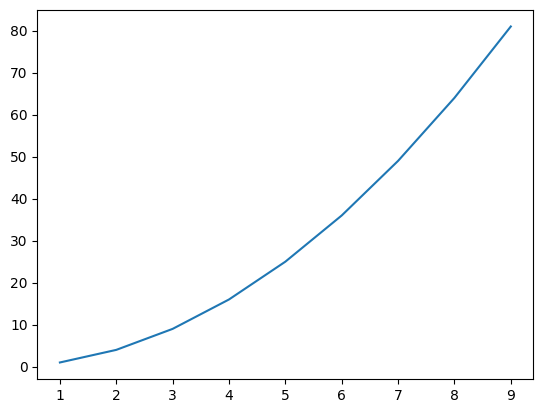

In [7]:
plt.plot(xf, yf)

In [8]:
a = Signal(2.0, label="a", op=Input)
b = Signal(-3.0, label="b", op=Input)
c = Signal(10.0, label="c", op=Input)
d = Signal(a * b + c, label="d")

In [9]:
h = 1

In [10]:
d2 = Signal((a+h) * b + c, label="d")

In [11]:
(d2 - d)/h

Signal(grad=1.0000, data=-3.0000)

In [12]:
d.backward()

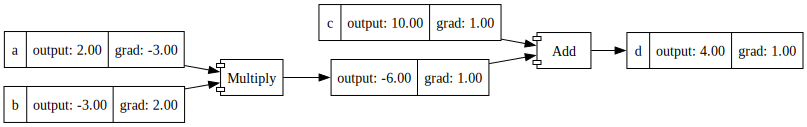

In [13]:
draw_dot(d)

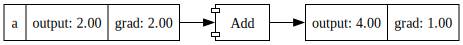

In [14]:
ad = Signal(2.0, label="a", op=Input)
cd = ad + ad
cd.backward()
draw_dot(cd)

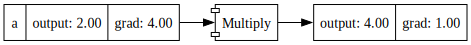

In [15]:
ac = Signal(2.0, label="a", op=Input)
dd = ac * ac
dd.backward()
draw_dot(dd)

In [16]:
in1 = Signal(2.0, label="IN(1)", op=Input)
in2 = Signal(0.0, label="IN(2)", op=Input)
w1 = Signal(-3.0, label="W(1)", op=Input)
w2 = Signal(1.0, label="W(2)", op=Input)
b = Signal(6.8813735870195432, label="B(N)", op=Input)
n = (in1 * w1) + (in2 * w2) + b

In [17]:
out = n.output
out.terminate()

Signal(grad=1.0000, data=0.7071)

In [18]:
out.backward()

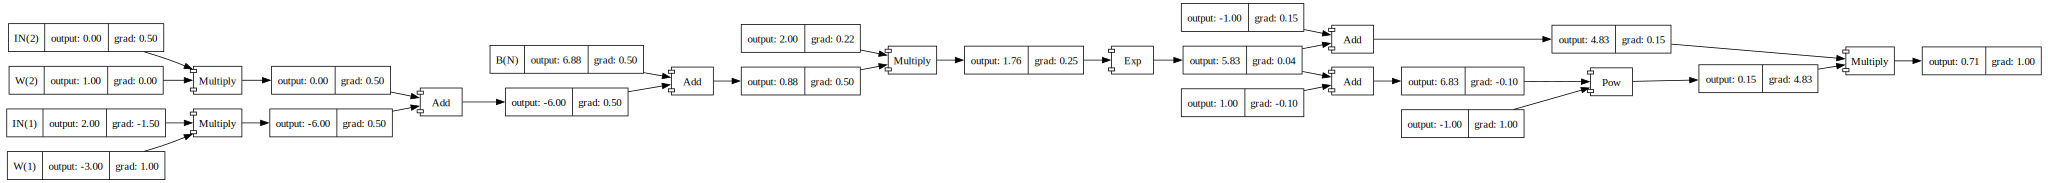

In [19]:
draw_dot(out)

In [20]:
h = 1
v = 2
val = Signal(v, label="IN")
expo = Exp.apply(val)

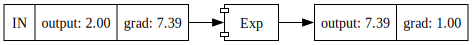

In [21]:
expo.backward()
draw_dot(expo)

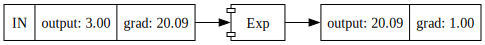

In [22]:
val2 = Signal(v+h, label="IN")
expo2 = Exp.apply(val2)
expo2.terminate()
expo2.backward()
draw_dot(expo2)

In [23]:
(expo2.data - expo.data)/h

12.696480824257018

In [24]:
class Neuron:
    def __init__(self, nw):
        self.weights = [Signal(random.uniform(-1,1)) for x in range(nw)]
        self.bias = Signal(random.uniform(-1, 1))
    def __call__(self, xin):
        return sum([ x * y for x, y in zip(self.weights, xin)] + [self.bias]).output

    def parameters(self):
        return self.weights + [self.bias]

In [25]:
nin = 4
n = Neuron(2)
xin = [float(x+1) for x in range(nin-1)]

In [26]:
output = n([2.0, 3.0])
output.terminate()
output

Signal(grad=1.0000, data=-0.6923)

In [27]:
class Layer:
    def __init__(self, nn, nw):
        self.neurons = [Neuron(nw) for _ in range(nn)]
        
    def __call__(self, yin):
        return [n(yin) for n in self.neurons]

    def parameters(self):
        return reduce(lambda acc, n: acc + n.parameters(), self.neurons, [])

In [28]:
class Mxx:
    def __init__(self, nin, layers):
        self.nin = nin
        lnweights = [nin] + layers
        self.layers = [Layer(layers[x], lnweights[x]) for x in range(len(layers))]
        
    def __call__(self, iz, terminate=True):
        return reduce(lambda acc, layer: layer(acc), self.layers, iz)

    
    def parameters(self):
        return reduce(lambda acc, l: acc + l.parameters(), self.layers, [])

In [29]:
in_samples = [
    [ 2.0,  3.0,  -1.0], 
    [ 3.0, -1.0,  0.5], 
    [ 0.5,  1.0,  1.0], 
    [ 1.0,  1.0,  -1.0]
]
validsamples = [1.0, -1.0, -1.0, 1.0]

In [30]:
## Too small to have reasonable fun :-(
signet = Mxx(3, [4, 4, 1])

In [31]:
predictions = [signet(x)[0] for x in in_samples]
loss = sum((xi - xo)**2 for xi, xo in zip(validsamples, predictions))
loss.backward()
loss

Signal(grad=1.0000, data=5.4485)

In [32]:
def trainsig(nnet, epoc):
    predictions = []
    loss = None
    for t in range(epoc):
        predictions = [nnet(x)[0] for x in in_samples]
        loss = sum((px - xg)**2 for xg, px in zip(validsamples, predictions))
        loss.backward()
        for p in nnet.parameters():
            #step = loss.data 
            p.data -= 0.01 * p.gradient
            
        for p in nnet.parameters():
            p.clear()
            
    return(loss, predictions)

In [33]:
(sloss, spredictions) = trainsig(signet, 100)
sloss

Signal(grad=1.0000, data=0.0301)

In [34]:
spredictions

[Signal(grad=-0.2001, data=0.9000),
 Signal(grad=0.2213, data=-0.8893),
 Signal(grad=0.1367, data=-0.9317),
 Signal(grad=-0.1124, data=0.9438)]